In [20]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):   # This basically allows us to print nicer looking expressions for the final output
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [21]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d= e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [22]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

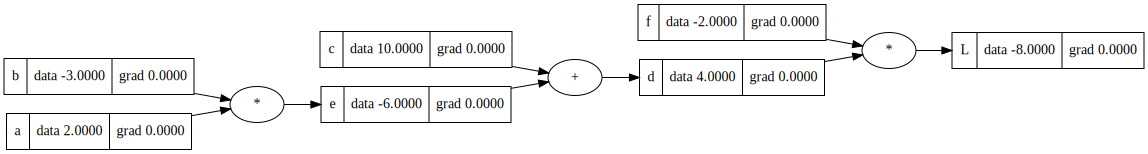

In [ ]:
draw_dot(L)

----------------------

### **Now, let's start to fill those grad values**

--------------

**Let's first find the derivative of L w.r.t L**

In [ ]:
#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.001

  #Here we are basically making them as local variables, to not affect the global variables on top
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data + h

  print((L2-L1)/h)

lol()

1.000000000000334


This was theoritically obvious as well. The derivitive of L wrt L will be one.

&nbsp;

So, lets add that value manually. (Remember to run the global variables for this)

In [23]:
L.grad = 1.0

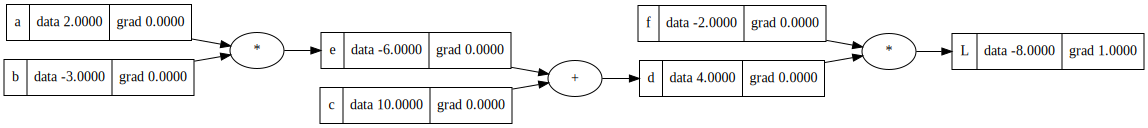

In [ ]:
draw_dot(L)

-----------

**Now, we find the derivative of L wrt to f and d**

So, mathematically:

dL/dd = ?

**L = d * f**

Therefore, dL/dd = f

If we do manual calculation to verify,           \

=> f(x+h) - f(x) / h                                \

(Remember the f(x) is basically L here)          \
=> (d+h)*f - d*f / h                                \
=> df + hf - df / h                                 \
=> hf/h                                             \
= f


So here if you see,

The derivative of L wrt f is the value in d \
& \
The derivative of L wrt d is the value in f

So, grad f is 4.0 \
and grad d is -2.0

&nbsp;

Lets check this in code!

In [ ]:
# STARTING WITH d

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  d.data = d.data + h
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-2.000000000000668


In [ ]:
# NOW WITH f

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0 + h, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

4.000000000026205


So, now that we have verified that mathematically and on our code. Lets manually add those variables to the graph

In [24]:
f.grad = 4.0
d.grad = -2.0

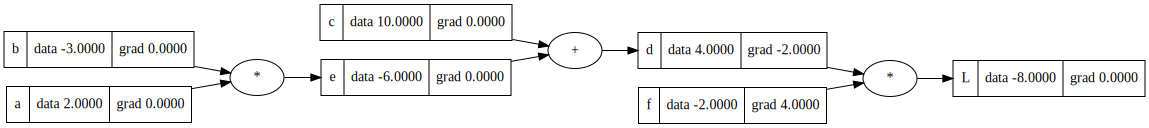

In [ ]:
draw_dot(L)

----------------------------

### **VERY IMPORTANT PART**

Now we'll be calculating the derivatives of the middle nodes

##### **Starting with c & e**

dL/dd had already been calculated (Check end of 4_1-manual-backpropagation notebook)

d = c + e

now,
Derivative of d wrt c, will be 1 \
Derivative of d wrt e, will be 1 \

&nbsp;

Because the derivative of '+' operation variables will lead to 1 (Calculus basics, it leads to constant, so 1)

&nbsp;

If we try to prove this mathematically:

&nbsp;

	d = c + e
	f(x+h) - f(x) / h
	Now, we'll calculate wrt c
	=> ( ((c+h)+e) - (c+e) ) / h
	=> c + h + e - c - e / h
	=> h / h
	=> 1
	Therefore, dd/dc = 1

&nbsp;

Therefore, we can just substitute the value respectively.

For node c:
	dL/dc = dL/dd . dd/dc \
  So here, the values should be -> dL/dc = -2.0 * 1 = -2.0

For node e:
	dL/de = dL/dd . dd/de \
  So here, the values should be -> dL/de = -2.0 * 1 = -2.0

In [ ]:
# NOW WITH c

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0 + h, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-1.999999987845058


In [ ]:
# NOW WITH e

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  e.data += h
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-1.9999999999242843


In [25]:
# Therefore, we now add those values manually
c.grad = -2.0
e.grad = -2.0

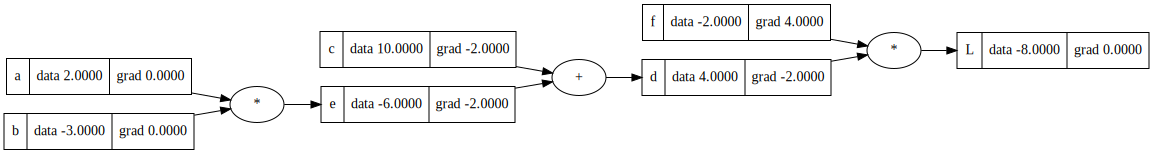

In [ ]:
draw_dot(L)

--------------

##### **Continuing with a & b**

Same principle as above, but a different kind of equation here.

&nbsp;

Also remember here, derivative of L wrt e was just calculated above^ (dL/de)

e = a * b

Therefore,
Derivative of e wrt a, will be b
Derivative of e wrt b, will be a

&nbsp;

Because the derivative of the same variable at the denominator gets out, so the other variable in the product remains (Calculus derivative theory itself)
	d/da(a * b) = b

&nbsp;

If we try to prove this mathematically,

&nbsp;

	e = a * b
	f(x+h) - f(x) / h
	Remember, f(x) is equation here. So, finding wrt a, substituting the values
	=> ( ((a + h) * b) - (a * b) ) / h
	=> ab + hb - ab / h
	=> hb / h
	=> b
	Therefore, de/da = b

&nbsp;

Therefore, we can just substitute the value respectively.

For node a:
	dL/da = dL/de . dd/da \
  So here, the values should be -> dL/da = -2.0 * -3.0 = 6.0

For node b:
	dL/db = dL/de . dd/db \
  So here, the values should be -> dL/db = -2.0 * 2.0 = -4.0

In [ ]:
# NOW WITH a

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

6.000000000128124


In [ ]:
# NOW WITH b

#This is just a staging function to show how the calculation of each of the derivative is taking place
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data #L is basically a node, so we need its data

  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label='e'
  d= e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data

  print((L2-L1)/h)

lol()

-4.000000000026205


In [26]:
#Now, we add those values manually
a.grad = 6.0
b.grad = -4.0

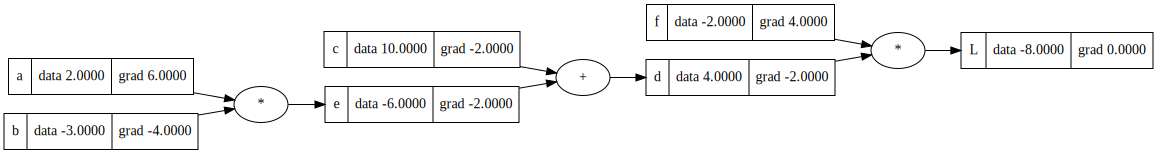

In [ ]:
draw_dot(L)

----------------

### **Hence the FINAL GENERATED GRAPH AFTER MANUAL BACKPROPAGATION!!**

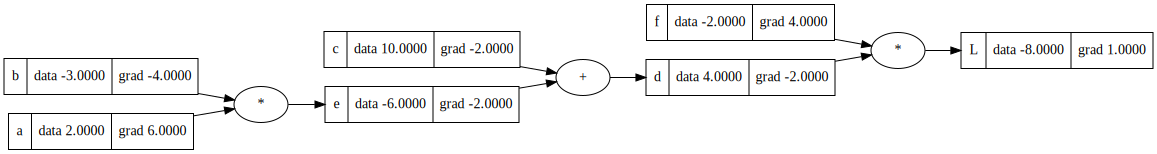

In [27]:
draw_dot(L)